# Analysing a sample ECG dataset
Agenda: reformat to use on AFDB and other datasets and include freq as variable

## Reading and preprocessing the dataset
First import all needed packages. To install wfdb, one needs to run "pip install wfdb" on Linux.

In [1]:
import wfdb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling as ov
import sklearn as sk
from scipy.stats import median_abs_deviation
from scipy.stats import entropy


from sklearn.model_selection import LeaveOneGroupOut

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score

import datetime


To download the dataset, use dl_databse function from wfdb package.

In [5]:
os.mkdir('data')
wfdb.dl_database('ltafdb', os.getcwd() + '/data')

Finished downloading files


In [2]:
print(os.getcwd())

/Users/vegy-math808y/Speciale/masters


Now read the data for a subject and find the sample numbers related to atrial fibrillation.

In [178]:
# For reading more about wfdb modules one can use help e.g. help(wfdb.rdsamp)
#ann = wfdb.rdann('data/ltafdb/01', 'atr')
ann = wfdb.rdann('data/afdb/04015', 'atr')

QRS = wfdb.rdann('data/afdb/04015', 'qrs')
QRS.symbol = pd.Series(QRS.symbol)
QRS.sample = pd.Series(QRS.sample)

ann.symbol = pd.Series(ann.symbol)
ann.sample = pd.Series(ann.sample)

# Boolean is used to find the indices of the R-peaks that are annotated with "A"
#boolean = pd.Series(ann.symbol=='A')
boolean = pd.Series(ann.symbol=='(N')
##NO AFDB data annotated w anything but 

#print(ann.sample[boolean].head(10))
#print(ann.sample[boolean].head(10))
#print(ann.sample)
print(ann.sample)
print(QRS.sample.tail(10))

0          30
1      102584
2      119604
3      121773
4      122194
5      133348
6      166857
7     1096245
8     1098054
9     1135296
10    1139595
11    1422436
12    1423548
13    1459277
14    1460416
dtype: int64
43995    8998087
43996    8998294
43997    8998489
43998    8998704
43999    8998914
44000    8999121
44001    8999327
44002    8999531
44003    8999734
44004    8999941
dtype: int64


Do the same for normal heart beats.

In [101]:
boolean = pd.Series(ann.symbol=='N')
print(ann.sample[boolean].head(10))

1     5969
3     6119
4     6232
6     6412
7     6495
8     6602
10    6781
11    6848
12    6939
14    7093
dtype: int64


Based on the above values, the region between 6200 and 7200 seems to have normal heart beat, while the region between 7300 and 8300 has atrial fibrillation. Now, read the samples related to these two regions using rdsamp and plot these regions to see the difference between atrial fibrillation and normal beats.

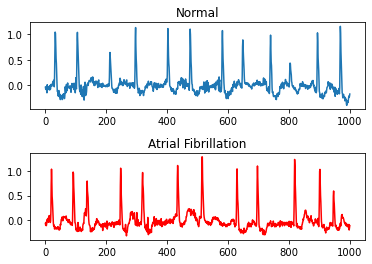

In [102]:
samp1 = wfdb.rdsamp('data/ltafdb/01',channels=[0], sampfrom=6200,sampto=7200)
samp2 = wfdb.rdsamp('data/ltafdb/01',channels=[0], sampfrom=7300,sampto=8300)
plt.subplot(2, 1, 1)
plt.title('Normal')
plt.plot(samp1[0])
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.5)
plt.title('Atrial Fibrillation')
plt.plot(samp2[0], color='red')
plt.show()

Define a class that is used to get every record, segment it, extract features, and label the segments.

In [5]:
class Subjects:
    """Subjects and their corresponding feature sets"""
# freq should be set to 1 if frequency is 250hz and 2 if 128hz to rescale annotation data.    
    def __init__(self, sample, symbol, freq):
        self.sample = pd.Series(list(sample)[1:])*freq
        #self.sample = pd.Series(list(sample)[1:])*250/freq
        self.sample = self.sample.round()
        self.symbol = pd.Series(list(symbol)[1:])
        self.filtr()
        self.calculaterr()
        

        
# Changes the indices of a series to range(0,length_of_the_series)
    def reindex(self, series):
        series = series.reset_index()
        series.drop('index', axis=1, inplace=True)
        return(series[0])
    
# Interpolate heart beats with NaNs (and divide heart beats into two classes: Normal and Abnormal)
    def filtr(self):
        self.symbol.interpolate(inplace=True)
        self.sample.interpolate(inplace=True)
        self.sample = self.reindex(self.sample)
        self.symbol = self.reindex(self.symbol)
        #self.symbol = self.symbol.replace('V', 'A')
        
# Claculate R-R intervals
    def calculaterr(self):
        self.rr = pd.Series(list(self.sample - self.sample.shift(1))[1:])

# Delete the end of the record if it is not divisible by segment length
    def cutend(self, n):
        self.sample = self.sample[0:(len(self.sample)//n)*n]
        self.symbol = self.symbol[0:(len(self.symbol)//n)*n]
        self.rr = self.rr[0:(len(self.sample)//n)*n]

# Calculate the sum of squares of distances between every two consecutive R-R intervals
    def dist(self, data):
        data = (data - data.shift(1))**2
        data = data.sum()
        return(data)
    
# Extract different features from the dataset (mean, standard deviation, RMSSD, and Normalised RMSSD)
    def extractfeatures(self, n):
        groups = self.rr.groupby(np.arange(len(self.rr))//n)
        self.means = groups.mean()
        self.sds = groups.std()        
        self.rmssd = np.sqrt(groups.apply(self.dist)/(n-1))
        self.nrmssd = self.rmssd/self.means
        ###added 
        #mean absolute deviation
        self.mad = groups.mad()
        #median absolute deviation
        self.medad = groups.apply(median_abs_deviation)
        #Shannon entropy 
        self.s_entropy = groups.apply(self.own_entropy)


# Compare the number of Abnormal beats to a given threshold (n*r).
# If all beats in a segment are unclassified, it returns abnormal
    def compare(self, data, n, r):
        numQ = sum(data == 'Q')
        n -= numQ
        numA = sum(data == 'A')
        if numA >= n * r:
            return 'A'
        else:
            return 'N'

# Set the label of each segment by comparing the ratio of abnormal beats to a given threshold (r)
    def label(self, n, r):
        groups = self.symbol.groupby(np.arange(len(self.symbol))//n)
        self.labels = groups.apply(self.compare, n, r)

# Segment records, label the segments, and extract features from them.
    def segment(self, n, r):
        if (len(self.rr)%n):
            self.cutend(n)
        self.extractfeatures(n)
        self.label(n, r)
        
    def own_entropy(self, signal, prob='standard'):
        ##(Code from: https://github.com/fraunhoferportugal/tsfel)
        """Computes the entropy of the signal using the Shannon Entropy.
        Description in Article:
        Regularities Unseen, Randomness Observed: Levels of Entropy Convergence
        Authors: Crutchfield J. Feldman David
        Feature computational cost: 1
        Parameters
        ----------
        signal : nd-array
            Input from which entropy is computed
        prob : string
            Probability function (kde or gaussian functions are available)
        Returns
        -------
        float
            The normalized entropy value
        """
        if prob == 'standard':
            value, counts = np.unique(signal, return_counts=True)
            p = counts / counts.sum()
        #elif prob == 'kde':
        #    p = kde(signal)
        #elif prob == 'gauss':
        #    p = gaussian(signal)
     
        if np.sum(p) == 0:
            return 0.0

        # Handling zero probability values
        p = p[np.where(p != 0)]

        # If probability all in one value, there is no entropy
        if np.log2(len(signal)) == 1:
            return 0.0
        elif np.sum(p * np.log2(p)) / np.log2(len(signal)) == 0:
            return 0.0
        else:
            return - np.sum(p * np.log2(p)) / np.log2(len(signal))

Read all ".atr" files and make them objects of the above class in order to segment them, extract features and label the segments.

In [56]:
#extract features and set up dataset

list_of_files = os.listdir('data/mitdb')
list_of_files = ['data/mitdb/' + i[:-4] for i in list_of_files if i.endswith('.dat')]
list_of_files_test = [list_of_files[1]]
print(list_of_files_test)
print(list_of_files)
data = pd.DataFrame({'id':[],'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'mad':[], 'medad':[], 's_entropy':[], 'label':[]},
                    columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy','label'])
print("entering loop")
k=1
for item in list_of_files:
    ann = wfdb.rdann(item, 'atr')
    subj = Subjects(ann.sample, ann.symbol, 2)
    types = ann.symbol
    values, counts = np.unique(types, return_counts=True)
    df = pd.DataFrame({'label':values, 'val':counts})
    #df = pd.DataFrame({'label': ann.symbol})
    #df1 = pd.DataFrame({'Rpeak': QRS.sample})
    print(df.groupby('label').val.sum())
    subj.segment(20, 1/2)
    #id=int(re.findall(r'\d+',item)[0])
    toappend = pd.DataFrame({'id':k,'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'mad':subj.mad, 'medad':subj.medad, 's_entropy': subj.s_entropy, 
                             'label':subj.labels}, columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy', 'label'])
    data = pd.concat([data, toappend])
    k+=1
    print("appended data")
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

data.describe(include="all")

#save DataFrame to pickle file
#data.to_pickle("data/ltafdb/data_features.pkl")

['data/mitdb/207']
['data/mitdb/213', 'data/mitdb/207', 'data/mitdb/212', 'data/mitdb/210', 'data/mitdb/205', 'data/mitdb/201', 'data/mitdb/215', 'data/mitdb/214', 'data/mitdb/200', 'data/mitdb/228', 'data/mitdb/202', 'data/mitdb/203', 'data/mitdb/217', 'data/mitdb/106', 'data/mitdb/112', 'data/mitdb/113', 'data/mitdb/107', 'data/mitdb/111', 'data/mitdb/105', 'data/mitdb/104', 'data/mitdb/114', 'data/mitdb/100', 'data/mitdb/101', 'data/mitdb/115', 'data/mitdb/103', 'data/mitdb/117', 'data/mitdb/116', 'data/mitdb/102', 'data/mitdb/124', 'data/mitdb/118', 'data/mitdb/119', 'data/mitdb/109', 'data/mitdb/121', 'data/mitdb/108', 'data/mitdb/122', 'data/mitdb/123', 'data/mitdb/232', 'data/mitdb/233', 'data/mitdb/231', 'data/mitdb/219', 'data/mitdb/230', 'data/mitdb/208', 'data/mitdb/220', 'data/mitdb/234', 'data/mitdb/221', 'data/mitdb/209', 'data/mitdb/223', 'data/mitdb/222']
entering loop
label
+      43
A      25
F     362
N    2641
V     220
a       3
Name: val, dtype: int64
appended dat

,id,mean,sd,rmssd,nrmssd,mad,medad,s_entropy,label
count,5607.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5605.000000,5607
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5374
mean,24.206349,554.027498,77.069207,106.861582,0.199783,57.650809,37.037288,0.909740,NaN
std,14.501001,121.359128,81.666739,121.560542,0.209009,63.315415,46.946480,0.067562,NaN
min,1.000000,173.900000,4.772730,6.537342,0.011140,3.720000,2.000000,0.602440,NaN
25%,11.000000,469.600000,19.417572,20.141604,0.035109,15.600000,11.000000,0.875578,NaN
50%,24.000000,537.200000,47.161983,61.853817,0.107141,31.100000,18.000000,0.921853,NaN
75%,38.000000,618.100000,112.515543,158.602449,0.320296,82.500000,43.000000,0.953724,NaN


In [40]:
# dataset input as string, sampfrq in hz
def build_dataframe(dataset, sampfrq): 
    list_of_files = os.listdir('data/'+dataset)
    list_of_files = ['data/'+dataset+'/' + i[:-4] for i in list_of_files if i.endswith('.atr')]
    list_of_files_test = [list_of_files[1]]
    print(list_of_files_test)
    print(list_of_files)
    data = pd.DataFrame({'id':[],'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'mad':[], 'medad':[], 's_entropy':[], 'label':[]},
                        columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy','label'])
    print("entering loop")
    k=1
    for item in list_of_files:
        ann = wfdb.rdann(item, 'atr')
        #print(ann.symbol[1:])
        #subj = Subjects(ann.sample, ann.symbol, sampfrq)
        subj = Subjects_AFDB(ann.sample, ann.symbol, sampfrq)
        subj.segment(20, 1/2)
        #id=int(re.findall(r'\d+',item)[0])
        toappend = pd.DataFrame({'id':k,'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                                 'mad':subj.mad, 'medad':subj.medad, 's_entropy': subj.s_entropy, 
                                 'label':subj.labels}, columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy', 'label'])
        data = pd.concat([data, toappend])
        k+=1
        print("appended data")
    data = data.reset_index()
    data.drop('index',axis=1,inplace=True)
    print(data.head(10))

    data.describe(include="all")

    #save DataFrame to pickle file
    data.to_pickle('data/'+dataset+'/data_features.pkl')

In [41]:
build_dataframe('ltafdb',128)
#build_dataframe('nsrdb',128)
build_dataframe('mitdb',360)

['data/ltafdb/25']
['data/ltafdb/118', 'data/ltafdb/25', 'data/ltafdb/19', 'data/ltafdb/18', 'data/ltafdb/24', 'data/ltafdb/30', 'data/ltafdb/119', 'data/ltafdb/26', 'data/ltafdb/32', 'data/ltafdb/33', 'data/ltafdb/122', 'data/ltafdb/23', 'data/ltafdb/37', 'data/ltafdb/22', 'data/ltafdb/121', 'data/ltafdb/08', 'data/ltafdb/34', 'data/ltafdb/20', 'data/ltafdb/21', 'data/ltafdb/35', 'data/ltafdb/120', 'data/ltafdb/47', 'data/ltafdb/53', 'data/ltafdb/45', 'data/ltafdb/51', 'data/ltafdb/44', 'data/ltafdb/68', 'data/ltafdb/54', 'data/ltafdb/55', 'data/ltafdb/69', 'data/ltafdb/208', 'data/ltafdb/43', 'data/ltafdb/42', 'data/ltafdb/56', 'data/ltafdb/204', 'data/ltafdb/72', 'data/ltafdb/205', 'data/ltafdb/207', 'data/ltafdb/64', 'data/ltafdb/70', 'data/ltafdb/58', 'data/ltafdb/71', 'data/ltafdb/65', 'data/ltafdb/206', 'data/ltafdb/202', 'data/ltafdb/49', 'data/ltafdb/75', 'data/ltafdb/74', 'data/ltafdb/60', 'data/ltafdb/48', 'data/ltafdb/203', 'data/ltafdb/201', 'data/ltafdb/62', 'data/ltafdb/

In [44]:
build_dataframe('nsrdb',128)

['data/nsrdb/19140']
['data/nsrdb/16272', 'data/nsrdb/19140', 'data/nsrdb/16273', 'data/nsrdb/16265', 'data/nsrdb/16539', 'data/nsrdb/17052', 'data/nsrdb/18177', 'data/nsrdb/19093', 'data/nsrdb/16773', 'data/nsrdb/19090', 'data/nsrdb/17453', 'data/nsrdb/19088', 'data/nsrdb/16795', 'data/nsrdb/16420', 'data/nsrdb/16786', 'data/nsrdb/18184', 'data/nsrdb/16483', 'data/nsrdb/19830']
entering loop
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
appended data
    id    mean         sd      rmssd    nrmssd     mad  medad  s_entropy label
0  1.0  236.00   8.503869   6.513145  0.027598   6.700    4.5   0.797431     N
1  1.0  234.95   4.524495   3.620119  0.015408   3.455    3.0   0.797431     N
2  1.0  240.65   5.070814   4.947088  0.020557   4.385    4.0   0.751155     N
3  1.0  227.35   7.421697   5.424118

In [37]:
#extract features and set up AFDB dataset
f = open("log.txt", "w")

list_of_files = os.listdir('data/afdb')
list_of_files = ['data/afdb/' + i[:-4] for i in list_of_files if i.endswith('.dat')]
#list_of_files_test = [list_of_files[1]]
list_of_files_test = ['data/afdb/00735']
print(list_of_files_test)
print(list_of_files)
data = pd.DataFrame({'id':[],'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'mad':[], 'medad':[], 's_entropy':[], 'label':[]},
                    columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy','label'])
print("entering loop")
k=1
for item in list_of_files:
    ann = wfdb.rdann(item, 'atr')
    QRS = wfdb.rdann(item, 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    #QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)    
    
    #print(QRS_Samp.describe())
    #print(Samp.describe())
    #print(Symb.describe())
    #print(Rhythm)
    #print(ann)

    #df1 = QRS_Samp.to_frame()
    df1 = pd.DataFrame({'Rpeak': QRS.sample})
    df1["label"]=np.nan
    ##print(df1.head(10))
    df2 = pd.DataFrame({'Rpeak': ann.sample,"label": ann.aux_note})
    ##print("dataframe2")
    ##print(df2.head(10))
    newdf = pd.concat([df1,df2], keys = ['1', '2'])
    newdf=newdf.sort_index(ascending=False) 
    #make sure that values from annotation file is on top even if Rpeaks are identical. Important for ffill
    newdf=newdf.sort_values(by=['Rpeak'])
    #perform forward fill to get annotation to all Rpeaks in QRS.sample
    newdf=newdf.ffill()
    #discard all Rpeaks+Annotations from ann.sample. Avoid adding extra or duplicate beats 
    newdf=newdf.loc[['1']]
    #print(newdf.groupby('label').describe())
    #print(QRS_Samp.describe())
    symbol = pd.Series(list(newdf["label"]))
  
    """
    #ann = wfdb.rdann(item, 'atr')
    #labeled_Rpeaks = pd.DataFrame({'index':[],'Label':[]})
    labeled_Rpeaks = []
    appended_data = []
    #df = pd.DataFrame({'index':[],'Label':[]})
    
    for j in range(len(Rhythm)-1):
        df = pd.DataFrame(QRS_Samp[(QRS_Samp > Samp[j]) & (QRS_Samp < Samp[j+1])])
        df['Label'] = Rhythm[j]
        #labeled_Rpeaks = pd.concat([labeled_Rpeaks,df])
        appended_data.append(df)
    
    labeled_Rpeaks = pd.concat(appended_data)
    print(labeled_Rpeaks.describe())
    print(labeled_Rpeaks)
    print(appended_data)
    
    """   


    subj = Subjects_AFDB(QRS.sample, symbol, 250)
    subj.segment(20, 1/2)
    toappend = pd.DataFrame({'id':k,'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'mad':subj.mad, 'medad':subj.medad, 's_entropy': subj.s_entropy, 
                             'label':subj.labels}, columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy', 'label'])
    data = pd.concat([data, toappend])
    k+=1
    print("appended data")
    f.write(f'{QRS_Samp.shape}\n')
    #f.write(f'N symbols is {symbol.shape}  for id  {k-1} ')
        
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

data.describe(include="all")

#save DataFrame to pickle file
data.to_pickle("data/afdb/data_features.pkl")
data.describe(include="all")

f.close()

['data/afdb/00735']
['data/afdb/08434', 'data/afdb/08378', 'data/afdb/08219', 'data/afdb/06426', 'data/afdb/05261', 'data/afdb/04746', 'data/afdb/07879', 'data/afdb/06453', 'data/afdb/04126', 'data/afdb/07162', 'data/afdb/08455', 'data/afdb/04043', 'data/afdb/04908', 'data/afdb/04048', 'data/afdb/04936', 'data/afdb/05091', 'data/afdb/06995', 'data/afdb/08215', 'data/afdb/08405', 'data/afdb/05121', 'data/afdb/04015', 'data/afdb/07859', 'data/afdb/07910']
entering loop
         Rpeak                                                               \
         count          mean           std        min        25%        50%   
label                                                                         
(AFIB   2310.0  2.421596e+06  1.082506e+05  2237244.0  2330043.0  2421527.0   
(N     37540.0  4.519179e+06  2.638215e+06      109.0  2068426.5  4535171.5   

                              
              75%        max  
label                         
(AFIB  2517845.25  2606599.0  
(N     6

In [12]:
print(data.groupby('id').describe())
print(data.describe(include="all"))

        mean                                                                 \
       count        mean        std    min      25%     50%      75%    max   
id                                                                            
1.0   1992.0  451.684689  51.343532  255.7  436.100  454.40  485.325  552.8   
2.0   2275.0  395.436440  81.627762  184.7  349.800  409.20  460.750  527.3   
3.0   2964.0  303.559244  26.128307  220.7  284.000  303.05  325.600  387.5   
4.0   2757.0  326.356148  39.747364  228.2  298.600  322.50  347.600  569.5   
5.0   2276.0  395.290290  41.093264  223.1  376.900  400.25  421.400  498.8   
6.0   2393.0  375.994609  92.359530  195.1  306.100  348.50  448.700  579.6   
7.0   2829.0  318.021421  81.772002  193.1  247.900  301.70  371.400  961.9   
8.0   1741.0  476.498449  39.926016  326.8  472.200  488.80  499.400  611.8   
9.0   2142.0  419.922923  82.905633  162.3  403.125  451.75  470.000  547.1   
10.0  1964.0  458.060183  45.089807  330.1  426.550 

In [32]:
class Subjects_AFDB:
    """Subjects and their corresponding feature sets"""
    
    
# freq should be set to 1 if frequency is 250hz and 2 if 128hz to rescale annotation data. try using actual freq as input   
    def __init__(self, sample, symbol, freq):
        #self.sample = pd.Series(list(sample)[1:])*freq
        self.sample = pd.Series(list(sample)[1:])*250/freq
        self.sample = self.sample.round()
        self.symbol = pd.Series(list(symbol)[1:])
        self.filtr()
        self.calculaterr()
        
        
# Changes the indices of a series to range(0,length_of_the_series)
    def reindex(self, series):
        series = series.reset_index()
        series.drop('index', axis=1, inplace=True)
        return(series[0])
    
# Interpolate heart beats with NaNs (and divide heart beats into two classes: Normal and Abnormal) 
##comment MJ: don't divide into two groups here. Keep V and other annotations. 
##replace to A or N for AFIB or Normal in order to reuse code    
    def filtr(self):
        ##define list to identify abnormal beats
        abnormal = ['(AFIB']
        """'(AFL', '(J', 'V']"""
        ##define list to identify normal beats
        normal = ['(N']
        self.symbol.interpolate(inplace=True)
        self.sample.interpolate(inplace=True)
        self.sample = self.reindex(self.sample)
        self.symbol = self.reindex(self.symbol)
        self.symbol = self.symbol.replace(abnormal, 'A')
        self.symbol = self.symbol.replace(normal, 'N')
        
# Claculate R-R intervals
    def calculaterr(self):
        self.rr = pd.Series(list(self.sample - self.sample.shift(1))[1:])

# Delete the end of the record if it is not divisible by segment length
    def cutend(self, n):
        self.sample = self.sample[0:(len(self.sample)//n)*n]
        self.symbol = self.symbol[0:(len(self.symbol)//n)*n]
        self.rr = self.rr[0:(len(self.sample)//n)*n]

# Calculate the sum of squares of distances between every two consecutive R-R intervals
    def dist(self, data):
        data = (data - data.shift(1))**2
        data = data.sum()
        return(data)
    
# Extract different features from the dataset (mean, standard deviation, RMSSD, and Normalised RMSSD)
    def extractfeatures(self, n):
        groups = self.rr.groupby(np.arange(len(self.rr))//n)
        self.means = groups.mean()
        self.sds = groups.std()        
        self.rmssd = np.sqrt(groups.apply(self.dist)/(n-1))
        self.nrmssd = self.rmssd/self.means
        ###added 
        #mean absolute deviation
        self.mad = groups.mad()
        #median absolute deviation
        self.medad = groups.apply(median_abs_deviation)
        #Shannon entropy 
        self.s_entropy = groups.apply(self.own_entropy)


# Compare the number of Abnormal beats to a given threshold (n*r).
# If all beats in a segment are unclassified, it returns abnormal

# #If number of  AFIB beats are above or equal to threshold set to A. 
##If number of normal beats are equal to threshhold set to N. Else set to O (Other) 
    def compare(self, data, n, r):
        #numQ = sum(data =='Q')
        #n -= numQ
        numA = sum(data =='A')
        numN = sum(data =='N')
        if numA >= n * r:
            return 'A'
        elif numN >= n * r:
            return 'N'
        else:
            return 'O'
        """
        if numA >= n * r:
            return 'A'
        else:
            return 'N'"""

# Set the label of each segment by comparing the ratio of abnormal beats to a given threshold (r)
    def label(self, n, r):
        groups = self.symbol.groupby(np.arange(len(self.symbol))//n)
        self.labels = groups.apply(self.compare, n, r)

# Segment records, label the segments, and extract features from them.
    def segment(self, n, r):
        if (len(self.rr)%n):
            self.cutend(n)
        self.extractfeatures(n)
        self.label(n, r)
        
    def own_entropy(self, signal, prob='standard'):
        ##(Code from: https://github.com/fraunhoferportugal/tsfel)
        """Computes the entropy of the signal using the Shannon Entropy.
        Description in Article:
        Regularities Unseen, Randomness Observed: Levels of Entropy Convergence
        Authors: Crutchfield J. Feldman David
        Feature computational cost: 1
        Parameters
        ----------
        signal : nd-array
            Input from which entropy is computed
        prob : string
            Probability function (kde or gaussian functions are available)
        Returns
        -------
        float
            The normalized entropy value
        """
        if prob == 'standard':
            value, counts = np.unique(signal, return_counts=True)
            p = counts / counts.sum()
        #elif prob == 'kde':
        #    p = kde(signal)
        #elif prob == 'gauss':
        #    p = gaussian(signal)
     
        if np.sum(p) == 0:
            return 0.0

        # Handling zero probability values
        p = p[np.where(p != 0)]

        # If probability all in one value, there is no entropy
        if np.log2(len(signal)) == 1:
            return 0.0
        elif np.sum(p * np.log2(p)) / np.log2(len(signal)) == 0:
            return 0.0
        else:
            return - np.sum(p * np.log2(p)) / np.log2(len(signal))

In [118]:
try:
    del data
except:
   pass
data = pd.read_pickle("data/afdb/data_features.pkl")


#print(data.head(10))

data.groupby('id')['label'].describe(include="all")
data.groupby('label').describe()
data.describe(include="all")


,id,mean,sd,rmssd,nrmssd,mad,medad,s_entropy,label
count,56413.000000,56413.000000,56413.000000,56413.000000,56413.000000,56413.000000,56413.000000,56413.000000,56413
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30382
mean,12.031003,182.600025,22.039124,30.539890,0.177316,16.737683,12.009696,0.840422,NaN
std,6.559953,42.187473,19.538080,28.367370,0.150465,14.979050,12.241778,0.137360,NaN
min,1.000000,81.150000,0.394034,0.561951,0.002559,0.190000,0.000000,0.172975,NaN
25%,6.000000,148.600000,3.886549,4.388981,0.021476,3.085000,2.500000,0.741267,NaN
50%,12.000000,175.400000,20.527966,28.544517,0.180283,13.820000,6.500000,0.884311,NaN
75%,18.000000,217.350000,34.659851,48.236806,0.292418,27.185000,20.000000,0.953724,NaN


In [92]:
data.groupby('label').describe()

id                                                      mean  \
         count       mean       std  min  25%   50%   75%   max    count   
label                                                                      
A      25430.0  13.003421  6.482442  1.0  7.0  12.0  19.0  23.0  25430.0   
N      30382.0  11.229050  6.510418  1.0  5.0  12.0  16.0  23.0  30382.0   
O        601.0  11.425957  6.767195  2.0  2.0  15.0  15.0  23.0    601.0   

                   ... medad        s_entropy                                \
             mean  ...   75%    max     count      mean       std       min   
label              ...                                                        
A      162.214564  ...  28.0   99.0   25430.0  0.950887  0.041522  0.490783   
N      201.056862  ...   4.0  113.5   30382.0  0.751745  0.118348  0.216123   
O      112.128619  ...   2.5   70.5     601.0  0.649158  0.199117  0.172975   

                                          
            25%       50%       75%  max  
label                                     
A      0.930587  0.953724  0.976862  1.0  
N      0.673009  0.756827  0.838035  1.0  
O      0.459396  0.704880  0.797431  1.0  

[3 rows x 64 columns]

# Do the same for the remaining three datasets
then go on to training in LOGO loop.

In [105]:
data.describe(include="all")

#save DataFrame to pickle file
data.to_pickle("data/ltafdb/data_features.pkl")

In [8]:
list_of_files = os.listdir('data/ltafdb')
print("read list")
list_of_files = ['data/ltafdb/' + i[:-4] for i in list_of_files if i.endswith('.atr')]
print("ready to get features")
data = pd.DataFrame({'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'label':[]},
                    columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
for item in list_of_files:
    ann = wfdb.rdann(item, 'atr')
    subj = Subjects(ann.sample, ann.symbol)
    subj.segment(10, 1/3)
    toappend = pd.DataFrame({'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'label':subj.labels}, columns=['mean', 'sd', 'rmssd', 'nrmssd', 'label'])
    data = pd.concat([data, toappend])
    print("appended line")
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

read list
ready to get features
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line
appended line


KeyboardInterrupt: 

In [61]:
#list_of_files = os.listdir('data/'+dataset)
#list_of_files = ['data/'+dataset+'/' + i[:-4] for i in list_of_files if i.endswith('.atr')]
list_of_files_test = ['data/mitdb/100']
print(list_of_files_test)
print(list_of_files)
data = pd.DataFrame({'id':[],'mean':[], 'sd':[], 'rmssd':[], 'nrmssd':[], 'mad':[], 'medad':[], 's_entropy':[], 'label':[]},
                    columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy','label'])
print("entering loop")
k=1
for item in list_of_files_test:
    ann = wfdb.rdann(item, 'atr')
    #print(ann.symbol[1:])
    #subj = Subjects(ann.sample, ann.symbol, sampfrq)
    subj = Subjects_AFDB(ann.sample, ann.symbol, 360)
    subj.segment(20, 1/2)
    #id=int(re.findall(r'\d+',item)[0])
    toappend = pd.DataFrame({'id':k,'mean':subj.means, 'sd':subj.sds, 'rmssd':subj.rmssd, 'nrmssd':subj.nrmssd,
                             'mad':subj.mad, 'medad':subj.medad, 's_entropy': subj.s_entropy, 
                             'label':subj.labels}, columns=['id','mean', 'sd', 'rmssd', 'nrmssd','mad','medad','s_entropy', 'label'])
    data = pd.concat([data, toappend])
    k+=1
    print("appended data")
data = data.reset_index()
data.drop('index',axis=1,inplace=True)
print(data.head(10))

data.groupby('label').describe()
#data.describe(include="all")

['data/mitdb/100']
['data/afdb/213', 'data/afdb/207', 'data/afdb/212', 'data/afdb/210', 'data/afdb/205', 'data/afdb/201', 'data/afdb/215', 'data/afdb/214', 'data/afdb/200', 'data/afdb/228', 'data/afdb/202', 'data/afdb/203', 'data/afdb/217', 'data/afdb/106', 'data/afdb/112', 'data/afdb/113', 'data/afdb/107', 'data/afdb/111', 'data/afdb/105', 'data/afdb/104', 'data/afdb/114', 'data/afdb/100', 'data/afdb/101', 'data/afdb/115', 'data/afdb/103', 'data/afdb/117', 'data/afdb/116', 'data/afdb/102', 'data/afdb/124', 'data/afdb/118', 'data/afdb/119', 'data/afdb/109', 'data/afdb/121', 'data/afdb/108', 'data/afdb/122', 'data/afdb/123', 'data/afdb/232', 'data/afdb/233', 'data/afdb/231', 'data/afdb/219', 'data/afdb/230', 'data/afdb/208', 'data/afdb/220', 'data/afdb/234', 'data/afdb/221', 'data/afdb/209', 'data/afdb/223', 'data/afdb/222']
entering loop
appended data
    id    mean         sd      rmssd    nrmssd    mad  medad  s_entropy label
0  1.0  202.85  14.995701  24.266069  0.119626  8.465    5

id                                      mean              ... medad  \
       count mean  std  min  25%  50%  75%  max  count        mean  ...   75%   
label                                                               ...         
N      113.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  113.0  198.758407  ...   5.5   

           s_entropy                                                    \
       max     count      mean       std       min       25%       50%   
label                                                                    
N      7.5     113.0  0.862001  0.043728  0.741267  0.838035  0.861173   

                           
            75%       max  
label                      
N      0.898715  0.953724  

[1 rows x 64 columns]

In [7]:
try:
    del data
except:
   pass
data = pd.read_pickle("data/afdb/data_features.pkl")


print(data.shape)
data=data.loc[data['label']!='O']
print(data.shape)
data.reset_index(drop=True, inplace=True)



        

"""
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=ids)


#newdata = df.groupby('column1')['column2'].apply(list)




ids = datacompress.loc[:, 'id']
print(ids)
np.array(ids)
""" 


datacompress = data.groupby('id').head(1)
print(datacompress)
X_split = datacompress
id_split = datacompress.pop('id')
y_split = datacompress.pop('label')

#ids = datacompress.loc[:, 'id']
print(id_split)
print(X_split)
print(y_split)


X = data
ids = data.pop('id')
y = data.pop('label')

print(ids.shape)
print(y.shape)
print(X.shape)   
y = y.map({'N':False ,'A':True})
y = y.astype(int)

logo = LeaveOneGroupOut()
logo.get_n_splits(groups=ids)

X=np.asarray(X)
y=np.asarray(y)

"""
X = data.loc[:, data.columns!='label']
y = data["label"]
##recode from cat to int 
y = y.map({'N':False ,'A':True})
y = y.astype(int)


#y = np.array(y, dtype=np.float64)
print(ids.shape)
print(X.shape)
print(y.shape)
y = np.array(y, dtype=np.float64)

print(X)
"""

(56413, 9)
(55812, 9)
         id    mean         sd       rmssd    nrmssd     mad  medad  \
0       1.0  207.65   3.048295    3.300718  0.015896   2.380    2.0   
1992    2.0  200.35  36.553170   63.472746  0.316809  17.485    2.5   
4090    3.0  153.05  30.644781   35.651825  0.232942  13.885    1.0   
7054    4.0  163.55  38.624338   56.263010  0.344011  31.615   19.0   
9794    5.0  213.40  65.989154  125.551625  0.588339  58.660   62.0   
12070   6.0  236.75   6.616367    5.052357  0.021340   5.250    4.0   
14463   7.0  220.45  19.993354   36.447511  0.165332  18.285    6.5   
17292   8.0  203.25   4.153312    5.221413  0.025690   3.350    3.0   
19033   9.0  196.75   5.963706    5.771983  0.029337   4.650    4.0   
21175  10.0  228.45  54.202811   83.953308  0.367491  42.995   43.0   
23139  11.0  200.90  24.836094   42.300305  0.210554  10.400    2.5   
26116  12.0  140.35   2.109502    3.501879  0.024951   1.650    1.5   
29209  13.0  154.35   3.437793    3.086473  0.019997   

'\nX = data.loc[:, data.columns!=\'label\']\ny = data["label"]\n##recode from cat to int \ny = y.map({\'N\':False ,\'A\':True})\ny = y.astype(int)\n\n\n#y = np.array(y, dtype=np.float64)\nprint(ids.shape)\nprint(X.shape)\nprint(y.shape)\ny = np.array(y, dtype=np.float64)\n\nprint(X)\n'

In [152]:
data.groupby('label').describe()

KeyError: 'label'

In [8]:
#define models to test
pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                             ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])
print("defined pipeline_svm")
pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                            ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                             ('rf_classifier', RandomForestClassifier(n_estimators=200))])
xgb_model = XGBClassifier(use_label_encoder=False)
adaBoost_clf = AdaBoostClassifier() 

estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf), ('adaboost', adaBoost_clf), ('xgboost', xgb_model)]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict')


defined pipeline_svm


In [9]:


print(pipeline_svm)

Pipeline(steps=[('scalar1', StandardScaler()),
                ('svm_classifier', SVC(C=20, probability=True))])


In [ ]:


metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[]},
                    columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1'])


model=pipeline_svm
modelname='pipeline_svm'

for train_index, test_index in logo.split(X, y, ids):
    print(datetime.datetime.now())
    print(train_index[0])
    print(train_index[-1]) 

    print('################################')
    print(test_index[0])
    print(test_index[-1])
      
    X_train, X_test = X[:train_index[-1]], X[test_index[0]:]
    y_train, y_test = y[:train_index[-1]], y[test_index[0]:]
    
    #y_train_all.append(y_train)
    #y_test_all.append(y_test)
    print(X_train.shape)
    print(f"shape of y: {np.shape(y_train)}, type of y: {type(y_train)}")
    print(f"shape of x: {np.shape(X_train)}, type of y: {type(y_train)}")

   
    pipeline_dt.fit(X_train,y_train)
    print("fitted")
  
    acc = pipeline_dt.score(X_test, y_test)
    y_pred = pipeline_dt.predict(X_test)
    
    
   
    tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_pred), labels=[0, 1]).ravel()
    #Sensitivity/Recall/TPR
    tpr= tp/(fn+tp)
    #Specificity/TNR
    tnr = tn/(tn+fp)
    #Precision/Positive Predictive value
    prec = tp/(tp+fp)
    #FPR
    fpr = fp/(tn+fp)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    toappend = pd.DataFrame({'model':modelname,'acc':acc, 'tpr':tpr, 'tnr':tnr, 'prec':prec,
                             'fpr':fpr, 'roc_auc':roc_auc, 'f1':f1}, 
                            columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1'])
    
    metrics = pd.concat([metrics, toappend])
    print("appended metrics")
   
    

In [10]:
def evaluate(X_test,y_test, model, modelname):
    acc = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_pred), labels=[0, 1]).ravel()
    #Sensitivity/Recall/TPR
    tpr= tp/(fn+tp)
    #Specificity/TNR
    tnr = tn/(tn+fp)
    #Precision/Positive Predictive value
    prec = tp/(tp+fp)
    #FPR
    fpr = fp/(tn+fp)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    toappend = pd.DataFrame({'model': [modelname] ,'acc':[acc], 'tpr':[tpr], 'tnr':[tnr], 'prec':[prec],'fpr':[fpr], 'roc_auc':[roc_auc], 'f1':[f1]}, 
                           columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1'])
    
    return toappend

In [12]:


metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[]},
                    columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1'])


models=[pipeline_svm]
modelnames=['pipeline_svm']

for train_index, test_index in logo.split(X, y, ids):
    print(datetime.datetime.now())
    print(train_index[0])
    print(train_index[-1]) 

    print('################################')
    print(test_index[0])
    print(test_index[-1])
      
    X_train, X_test = X[:train_index[-1]], X[test_index[0]:]
    y_train, y_test = y[:train_index[-1]], y[test_index[0]:]
    
    #y_train_all.append(y_train)
    #y_test_all.append(y_test)
    print(X_train.shape)
    print(f"shape of y: {np.shape(y_train)}, type of y: {type(y_train)}")
    print(f"shape of x: {np.shape(X_train)}, type of y: {type(y_train)}")

    a=0
    for model in models:    
        model.fit(X_train,y_train)
        print("fitted")
        
        evaluate(X_test,y_test, model, modelnames[a])
        
        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        a += 1

    

2023-01-26 13:17:36.048604
1992
55811
################################
0
1991
(55811, 7)
shape of y: (55811,), type of y: <class 'numpy.ndarray'>
shape of x: (55811, 7), type of y: <class 'numpy.ndarray'>
fitted


NameError: name 'roc_auc_score' is not defined

In [ ]:





logo = LeaveOneGroupOut()
ids = data.loc[:, 'ids']
logo.get_n_splits(groups=ids)


labeled_Rp.reset_index(drop=True, inplace=True)

Rpeaks_N_AFIB = data["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

seg_len = 20
y_pred_svm_all_ts = []
y_pred_dt_all_ts = []
y_pred_rf_all_ts = []
y_pred_stacking_all_ts = []
y_pred_xgboost_all_ts = []
y_pred_adaboost_all_ts = []
y_score_svm_all_ts = []
y_score_dt_all_ts = []
y_score_rf_all_ts = []
y_score_stacking_all_ts = []
y_score_xgboost_all_ts = []
y_score_adaboost_all_ts = []
y_prob_svm_all_ts = []
y_prob_dt_all_ts = []
y_prob_rf_all_ts = []
y_prob_stacking_all_ts = []
y_prob_xgboost_all_ts = []
y_prob_adaboost_all_ts = []

y_pred_svm_all_tr = []
y_pred_dt_all_tr = []
y_pred_rf_all_tr = []
y_pred_stacking_all_tr = []
y_pred_xgboost_all_tr = []
y_pred_adaboost_all_tr = []
y_score_svm_all_tr = []
y_score_dt_all_tr = []
y_score_rf_all_tr = []
y_score_stacking_all_tr = []
y_score_xgboost_all_tr = []
y_score_adaboost_all_tr = []
y_prob_svm_all_tr = []
y_prob_dt_all_tr = []
y_prob_rf_all_tr = []
y_prob_stacking_all_tr = []
y_prob_xgboost_all_tr = []
y_prob_adaboost_all_tr = []

y_train_all = []
y_test_all = []

y_tr_all = []
y_ts_all = []


for train_index, test_index in logo.split(Rpeaks_N_AFIB, Label_N_AFIB, ids):
    print(datetime.datetime.now())
    print(train_index)
    print('################################')
    print(test_index)
    
    X_train, X_test = Rpeaks_N_AFIB[train_index], Rpeaks_N_AFIB[test_index]
    y_train, y_test = Label_N_AFIB[train_index], Label_N_AFIB[test_index]

    y_train_all.append(y_train)
    y_test_all.append(y_test)

    ###################### Train AFDB ###################################

    print(X_train.shape)
    print(X_train)

    segmented_record_tr, amount_tr, seg_shape_tr = segmenting_record(seg_len, X_train)


    print(segmented_record_tr.shape)
    print(segmented_record_tr)

    %run "features_utils.ipynb"
    print('2')
    all_features_tr = []

    ### Calculating all_features for every single segmented "block" inside the segmented_record variable
    for x in range(len(segmented_record_tr)):

        #MEAN
        ff1_tr = np.nanmean(segmented_record_tr[x]) ### nanmean, nanstd computes values while ignoring nan-values
        #STD
        ff2_tr = np.nanstd(segmented_record_tr[x])
        #RMSSD
        sum_tr = 0
        for y in range(len(segmented_record_tr[x]) - 1): ### loops 19 times for segment=20
            sum_tr += (segmented_record_tr[x][y] - segmented_record_tr[x][y+1])**2
        sum_multiplied_tr = 1/(len(segmented_record_tr) - 1) * sum_tr
        ff3_tr = np.sqrt(sum_multiplied_tr)
        #NORMALIZED RMSSD
        ff4_tr = (ff3_tr / ff1_tr)
        #SHANNON ENTROPY
        ff5_tr = entropy(segmented_record_tr[x])
        #MEAN ABSOLUTE DEVIATION
        #*#ff6_tr = mean_abs_deviation(segmented_record_tr[x])
        #MEDIAN ABSOLUTE DEVIATION
        #*#ff7_tr = median_abs_deviation(segmented_record_tr[x], scale=1)
        
                

        my_all_features_tr = pd.Series(
                                    [np.around(ff1_tr,3), np.around(ff2_tr,3), np.around(ff3_tr,3), np.around(ff4_tr,3),
                                        np.around(ff5_tr,3)], #*#np.around(ff6_tr,3), np.around(ff7_tr,3)],
                                index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy']
                                    )
                                      #*# 'Mean absolute deviation','Median absolute deiviation'])
        all_features_tr.append(my_all_features_tr)
        
        

    print("stepping out of featureloop")
    y_amount_tr = y_train[:amount_tr] 
    y_shape_tr = y_amount_tr.reshape(seg_shape_tr, seg_len) 

    y_list_tr = []

    ### Calc if every 20 segment block is Normal synus rythm or AFIB
    for l in range(len(y_shape_tr)):
        #y_segment = y_shape
        sum_segment_tr = np.sum(y_shape_tr[l])
        if sum_segment_tr >= int(seg_len/2): 
            sum_segment_tr = 1
        else: sum_segment_tr = 0
        y_list_tr.append(sum_segment_tr)

    y_list_tr = np.array(y_list_tr, dtype=np.float64)
    print(f"Length: {len(y_list_tr)}, Type: {y_list_tr.dtype}")
    
    

    ##### Chosen params after hyperparameters tuning using GridsearchCV 

    pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                             ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])
    print("defined pipeline_svm")
    pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                            ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

    pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                             ('rf_classifier', RandomForestClassifier(n_estimators=200))])
    xgb_model = XGBClassifier(use_label_encoder=False)

    adaBoost_clf = AdaBoostClassifier() 

    estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('rf',pipeline_rf), ('adaboost', adaBoost_clf), ('xgboost', xgb_model)]
    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict')

    y_tr = np.asarray(y_list_tr)
    print(f"shape of y: {np.shape(y_tr)}, type of y: {type(y_tr)}")
    X_tr = np.asarray(all_features_tr)
    print(f"shape of X: {np.shape(X_tr)}, type of X: {type(X_tr)}")

    y_tr_all.append(y_tr)
    
    print(3)

    pipeline_svm.fit(X_tr, y_tr)
    pipeline_dt.fit(X_tr, y_tr)
    pipeline_rf.fit(X_tr, y_tr)
    clf.fit(X_tr, y_tr)
    xgb_model.fit(X_tr, y_tr)
    adaBoost_clf.fit(X_tr, y_tr)
    
    y_pred_svm_tr = pipeline_svm.predict(X_tr)
    y_pred_dt_tr = pipeline_dt.predict(X_tr)
    y_pred_rf_tr = pipeline_rf.predict(X_tr)
    y_pred_stacking_tr = clf.predict(X_tr)
    y_pred_xgboost_tr = xgb_model.predict(X_tr)
    y_pred_adaboost_tr = adaBoost_clf.predict(X_tr)
    
    y_prob_svm_tr = pipeline_svm.predict_proba(X_tr)
    y_prob_dt_tr = pipeline_dt.predict_proba(X_tr)
    y_prob_rf_tr = pipeline_rf.predict_proba(X_tr)
    y_prob_stacking_tr = clf.predict_proba(X_tr)
    y_prob_xgboost_tr = xgb_model.predict_proba(X_tr)
    y_prob_adaboost_tr = adaBoost_clf.predict_proba(X_tr)
    
    print("appending training predeictions")

    y_pred_svm_all_tr.append(y_pred_svm_tr)
    y_pred_dt_all_tr.append(y_pred_dt_tr)
    y_pred_rf_all_tr.append(y_pred_rf_tr)
    y_pred_stacking_all_tr.append(y_pred_stacking_tr)
    y_pred_xgboost_all_tr.append(y_pred_xgboost_tr)
    y_pred_adaboost_all_tr.append(y_pred_adaboost_tr)
    
    y_prob_svm_all_tr.append(y_pred_svm_tr)
    y_prob_dt_all_tr.append(y_pred_dt_tr)
    y_prob_rf_all_tr.append(y_pred_rf_tr)
    y_prob_stacking_all_tr.append(y_pred_stacking_tr)
    y_prob_xgboost_all_tr.append(y_pred_xgboost_tr)
    y_prob_adaboost_all_tr.append(y_pred_adaboost_tr)

    ###################### Test AFDB ###################################

    segmented_record_ts, amount_ts, seg_shape_ts = segmenting_record(seg_len, X_test)

    print('test')
    print(segmented_record_ts.shape)
    print(segmented_record_ts)

    %run "features_utils.ipynb"

    all_features_ts = []

    ### Calculating all_features for every single segmented "block" inside the segmented_record variable
    for x in range(len(segmented_record_ts)):

        #MEAN
        ff1_ts = np.nanmean(segmented_record_ts[x]) ### nanmean, nanstd computes values while ignoring nan-values
        #STD
        ff2_ts = np.nanstd(segmented_record_ts[x])
        #RMSSD
        sum_ts = 0
        for y in range(len(segmented_record_ts[x]) - 1): ### loops 19 times for segment=20
            sum_ts += (segmented_record_ts[x][y] - segmented_record_ts[x][y+1])**2
        sum_multiplied_ts = 1/(len(segmented_record_ts) - 1) * sum_ts
        ff3_ts = np.sqrt(sum_multiplied_ts)
        #NORMALIZED RMSSD
        ff4_ts = (ff3_ts / ff1_ts)
        #SHANNON ENTROPY
        ff5_ts = entropy(segmented_record_ts[x])
        #MEAN ABSOLUTE DEVIATION
        #*#ff6_ts = mean_abs_deviation(segmented_record_ts[x])
        #MEDIAN ABSOLUTE DEVIATION
        #*#ff7_ts = median_abs_deviation(segmented_record_ts[x], 1)
        
  
        my_all_features_ts = pd.Series([np.around(ff1_ts, 3), np.around(ff2_ts, 3), np.around(ff3_ts,3), np.around(ff4_ts,  3),
                                        np.around(ff5_ts, 3)], #*# np.around(ff6_ts, 3), np.around(ff7_ts, 3)],
                                index=['Mean','STD','RMSSD','Normalized RMSSD','Shannon Entropy']
                                      )
                                       #*#'Mean absolute deviation','Median absolute deiviation'])
        all_features_ts.append(my_all_features_ts)
       


    y_amount_ts = y_test[:amount_ts] 
    y_shape_ts = y_amount_ts.reshape(seg_shape_ts, seg_len) 

    y_list_ts = []

    ### Calc if every 20 segment block is Normal synus rythm or AFIB
    for l in range(len(y_shape_ts)):
        #y_segment = y_shape
        sum_segment_ts = np.sum(y_shape_ts[l])
        if sum_segment_ts >= int(seg_len/2): 
            sum_segment_ts = 1
        else: sum_segment_ts = 0
        y_list_ts.append(sum_segment_ts)

    y_list_ts = np.array(y_list_ts, dtype=np.float64)
    print(f"Length: {len(y_list_ts)}, Type: {y_list_ts.dtype}")

    y_ts = np.asarray(y_list_ts)
    print(f"shape of y: {np.shape(y_ts)}, type of y: {type(y_ts)}")
    X_ts = np.asarray(all_features_ts)
    print(f"shape of X: {np.shape(X_ts)}, type of X: {type(X_ts)}")

    y_ts_all.append(y_ts)

    y_pred_svm_ts = pipeline_svm.predict(X_ts)
    y_pred_dt_ts = pipeline_dt.predict(X_ts)
    y_pred_rf_ts = pipeline_rf.predict(X_ts)
    y_pred_stacking_ts = clf.predict(X_ts)
    y_pred_xgboost_ts = xgb_model.predict(X_ts)
    y_pred_adaboost_ts = adaBoost_clf.predict(X_ts)
    
    y_score_svm_ts = pipeline_svm.predict_proba(X_ts)
    y_score_dt_ts = pipeline_dt.predict_proba(X_ts)
    y_score_rf_ts = pipeline_rf.predict_proba(X_ts)
    y_score_stacking_ts = clf.predict_proba(X_ts)
    y_score_xgboost_ts = xgb_model.predict_proba(X_ts)
    y_score_adaboost_ts = adaBoost_clf.predict_proba(X_ts)

    y_pred_svm_all_ts.append(y_pred_svm_ts)
    y_pred_dt_all_ts.append(y_pred_dt_ts)
    y_pred_rf_all_ts.append(y_pred_rf_ts)
    y_pred_stacking_all_ts.append(y_pred_stacking_ts)
    y_pred_xgboost_all_ts.append(y_pred_xgboost_ts)
    y_pred_adaboost_all_ts.append(y_pred_adaboost_ts)
    
    y_score_svm_all_ts.append(y_pred_svm_ts)
    y_score_dt_all_ts.append(y_pred_dt_ts)
    y_score_rf_all_ts.append(y_pred_rf_ts)
    y_score_stacking_all_ts.append(y_pred_stacking_ts)
    y_score_xgboost_all_ts.append(y_pred_xgboost_ts)
    y_score_adaboost_all_ts.append(y_pred_adaboost_ts)

In [ ]:
        model.fit(X_train,y_train)
        acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        
        tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_pred), labels=[0, 1]).ravel()
        tpr= tp/(fn+tp)
        tnr = tn/(tn+fp)
        roc_auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        tpr_list.append(tpr)
        tnr_list.append(tnr)
        acc_list.append(acc)
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

    
    print(model)
    print("mean accuracy is {}.". format(np.mean(acc_list)))
    print("mean true positive rate is {}.". format(np.mean(tpr_list)))
    print("mean true negative rate is {}.". format(np.mean(tnr_list)))
    print("mean AUC for ROC curve is {}.". format(np.mean(roc_auc_list)))
    print("mean F1 score {}.". format(np.mean(f1_list))) 